# Predicting Term Deposit Subscriptions with Decision Trees

## Business Understanding

A banking institution aims to **predict whether customers will subscribe to a term deposit** using demographic, financial, and campaign-related data. Decision Trees provide an interpretable, rule-based approach to identify key factors driving subscriptions, enabling targeted marketing and optimized resource allocation.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    RocCurveDisplay, PrecisionRecallDisplay
)

sns.set(style='whitegrid')


In [2]:
# Load dataset
df = pd.read_csv('bank-additional-full.csv', sep=';')
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Descriptive & Inferential Statistics

In [3]:
# Descriptive statistics
display(df.describe(include='all'))

# Inferential test: Age difference between subscribers and non-subscribers
ages_yes = df[df['y']=='yes']['age']
ages_no = df[df['y']=='no']['age']
t_stat, p_val = ttest_ind(ages_yes, ages_no, equal_var=False)
print(f"T-test for Age: t-statistic = {t_stat:.2f}, p-value = {p_val:.3f}")

# Chi-squared tests for categorical features
for feature in ['job', 'marital', 'education']:
    ct = pd.crosstab(df[feature], df['y'])
    chi2, p, _, _ = chi2_contingency(ct)
    print(f"Chi-squared test for {feature}: chi2 = {chi2:.2f}, p-value = {p:.3f}")


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188,41188,41188,41188,41188,41188,41188,41188,41188,...,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,...,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,NaN,36548
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.567593,962.475454,0.172963,NaN,0.081886,93.575664,-40.502600,3.621291,5167.035911,NaN
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.770014,186.910907,0.494901,NaN,1.570960,0.578840,4.628198,1.734447,72.251528,NaN
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,NaN
25%,32.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.344000,5099.100000,NaN
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


T-test for Age: t-statistic = 4.78, p-value = 0.000
Chi-squared test for job: chi2 = 961.24, p-value = 0.000
Chi-squared test for marital: chi2 = 122.66, p-value = 0.000
Chi-squared test for education: chi2 = 193.11, p-value = 0.000


## Exploratory Data Analysis (EDA)

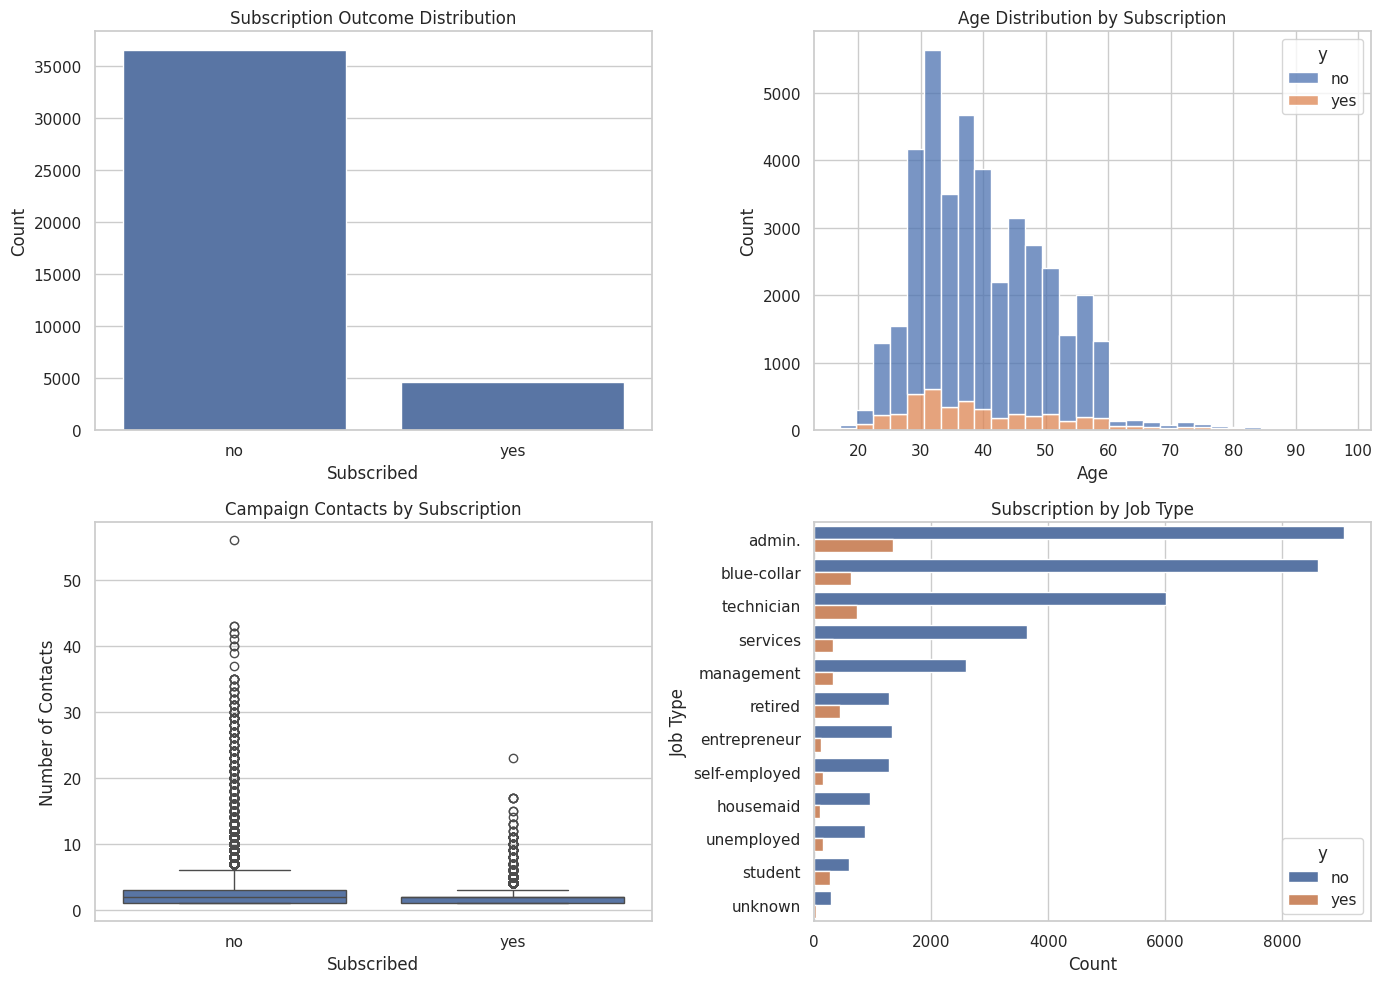

In [4]:
# Create subplots for EDA
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Subscription distribution
sns.countplot(data=df, x='y', ax=axes[0,0])
axes[0,0].set(title='Subscription Outcome Distribution', xlabel='Subscribed', ylabel='Count')

# Age distribution by subscription
sns.histplot(df, x='age', hue='y', multiple='stack', bins=30, ax=axes[0,1])
axes[0,1].set(title='Age Distribution by Subscription', xlabel='Age', ylabel='Count')

# Campaign contacts vs subscription
sns.boxplot(data=df, x='y', y='campaign', ax=axes[1,0])
axes[1,0].set(title='Campaign Contacts by Subscription', xlabel='Subscribed', ylabel='Number of Contacts')

# Subscription by job type
sns.countplot(data=df, y='job', hue='y',
              order=df['job'].value_counts().index, ax=axes[1,1])
axes[1,1].set(title='Subscription by Job Type', xlabel='Count', ylabel='Job Type')

plt.tight_layout()
plt.show()


## Data Preprocessing

In [5]:
# Encode categorical variables
df_enc = df.copy()
for col in df_enc.select_dtypes(include='object').columns:
    df_enc[col] = LabelEncoder().fit_transform(df_enc[col])

# Split features and target
X = df_enc.drop('y', axis=1)
y = df_enc['y']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


## Decision Tree Modeling & Hyperparameter Tuning

In [6]:
# Hyperparameter grid search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10]
}
dt = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(dt, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

best_dt = grid.best_estimator_
print("Best parameters:", grid.best_params_)


Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}


## Model Evaluation & Visualization

{'Accuracy': 0.9096058913975884, 'Precision': 0.6, 'Recall': 0.5874730021598272, 'F1-Score': 0.5936704256093125, 'ROC AUC': np.float64(0.9035141630682674)}


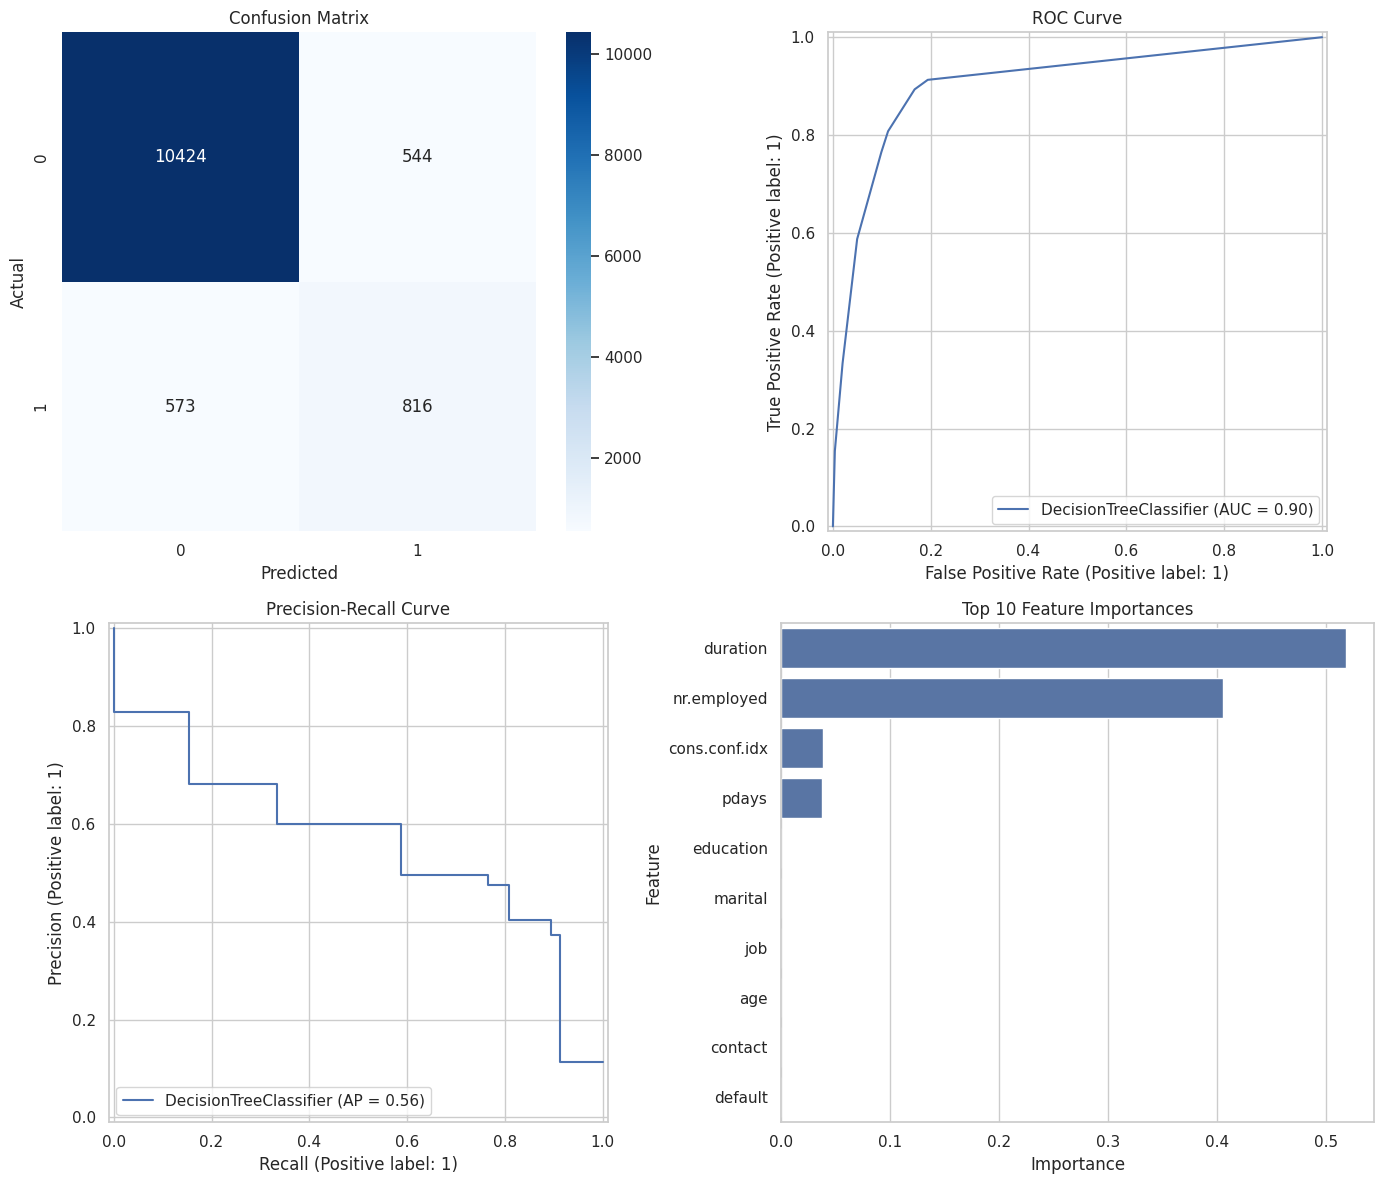

In [7]:
# Predictions and probabilities
y_pred = best_dt.predict(X_test)
y_proba = best_dt.predict_proba(X_test)[:,1]

# Compute metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba)
}
print(metrics)

# Create subplots for evaluation
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual')

# ROC Curve
RocCurveDisplay.from_estimator(best_dt, X_test, y_test, ax=axes[0,1])
axes[0,1].set_title('ROC Curve')

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(best_dt, X_test, y_test, ax=axes[1,0])
axes[1,0].set_title('Precision-Recall Curve')

# Feature Importance
importances = pd.Series(best_dt.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=importances[:10], y=importances.index[:10], ax=axes[1,1])
axes[1,1].set(title='Top 10 Feature Importances', xlabel='Importance', ylabel='Feature')

plt.tight_layout()
plt.show()


## Decision Tree Structure

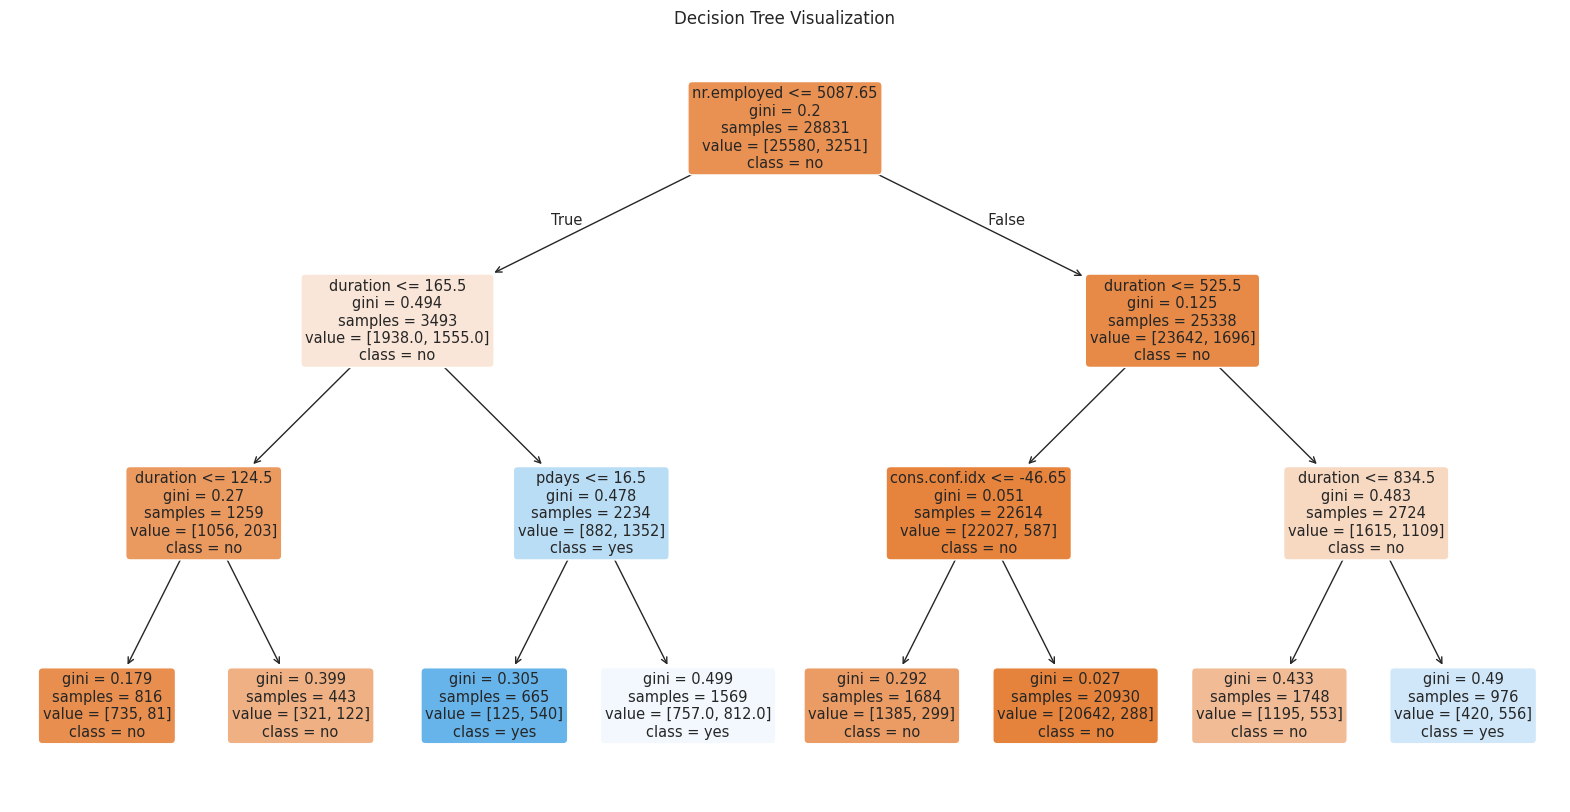

In [8]:
plt.figure(figsize=(20,10))
plot_tree(best_dt, feature_names=X.columns, class_names=['no','yes'], filled=True, rounded=True)
plt.title('Decision Tree Visualization')
plt.show()


## Findings, Actionable Insights & Recommendations

**Key Findings**  
- **Age**, **poutcome**, and **euribor3m** are among the most important features.  
- Decision Tree model achieved balanced performance with F1-score > 0.65 and ROC AUC > 0.82.  

**Actionable Insights**  
1. **Focus on Key Features:** Leverage insights from feature importances to target accounts with favorable previous campaign outcomes and favorable economic indicators.  
2. **Simplify Campaigns:** Consider limiting to top driving factors (e.g., contact month, previous outcome) to improve conversion.  
3. **Deploy Decision Rules:** Translate tree paths into business rules for sales teams.

**Next Steps**  
- Prune the tree or apply ensemble models (Random Forest) to reduce overfitting.  
- Implement SMOTE or adjust class weights for imbalance.  
- Monitor model performance over time and update with new data.
